[Reference](https://pub.towardsai.net/neural-network-from-scratch-6fa1e78a3515)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

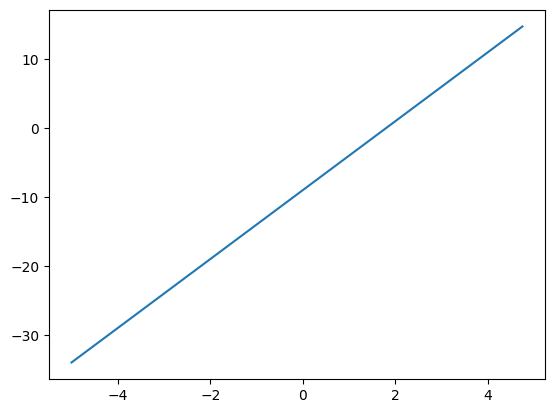

In [2]:
def f(x):
  return 5*x - 9

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
class Value:
    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        self.grad = 0.0 # We'll go over this field in detail later on
    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"

'''
Let's make use of a multi-variate equation and write it using the Value class defined above
a = 2.0
b = -3.0
c = 10.0
e = a * b
d = e + c
f = -2.0
l = d * f
'''
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b

TypeError: unsupported operand type(s) for *: 'Value' and 'Value'

In [4]:
class Value:
    def __init__(self, data, _children=(),   _op='', label=''):
        self.data = data
        self.label = label
        self._op = _op
        self._prev = set(_children)
        self.grad = 0

    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value=(data=-8.0, label=L)

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

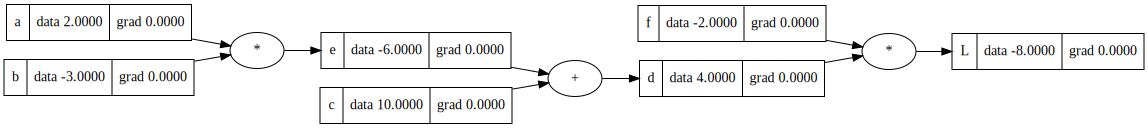

In [6]:
'''
Plotting the variable L to layout the network. The _op nodes are just rendered to show the parent/child relation between nodes
'''
draw_dot(L)

In [7]:
L.grad = 1.0 # Base case as rate of change of L wrt to L is 1
'''
We know that L = d*f
so dL/de (gradient of L wrt to f or rate of change of L wrt to f) = d
similarly dL/dd will be f
'''

d.grad = f.data
f.grad = d.data

'''
Since d = e + c, to find out dL/dd (Rate of change of L wrt to d) we'll make use of the chain rule i.e
dL/de = (dL/dd) * (dd/de) = (dL/dd) * 1.0
similarly dL/dc = dL/dd * 1.0
'''
e.grad =  d.grad
c.grad = d.grad

'''
e = a * b
So following the chain rule again
dL/da = (dL/de) * (de/da) = (dL/de) * b
dL/db = (dL/de) * (de/db) = (dL/de) * a
'''
a.grad = e.grad * b.data
b.grad = e.grad * a.data

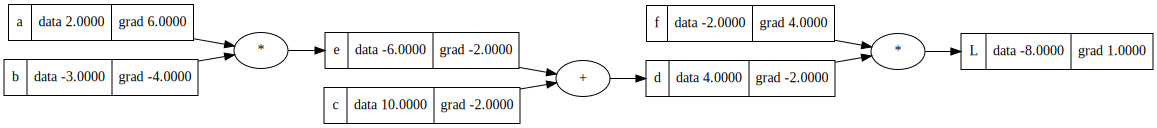

In [8]:
'''
Plotting the variable L to layout the network.
'''
draw_dot(L)

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

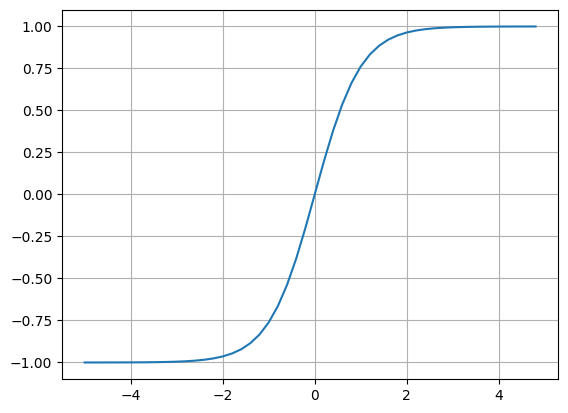

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

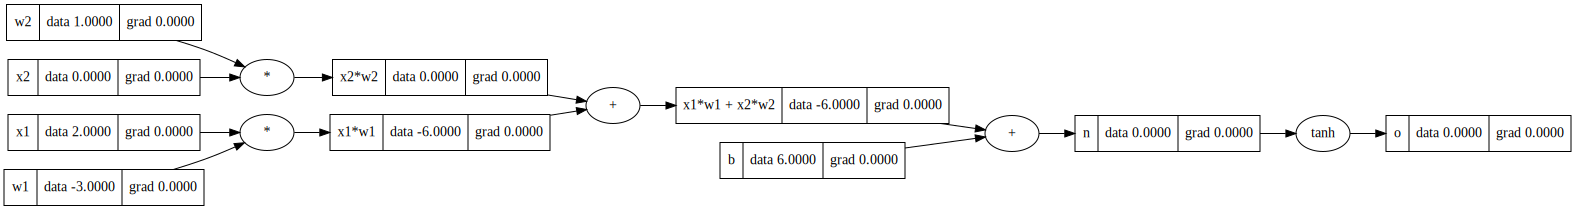

In [11]:
'''
We'll pass n through an activation function tanh but before that we'll need to add tanh to the Value type since tanh doesn't understand Value type.
'''

def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

# Attach the instance method to the class
Value.tanh = tanh

o = n.tanh(); o.label = 'o'
draw_dot(o)

In [12]:
'''
Updating Value to include _backward function for each operation method
'''

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

In [13]:
'''Reinitializing the values to reflect new class properties '''
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

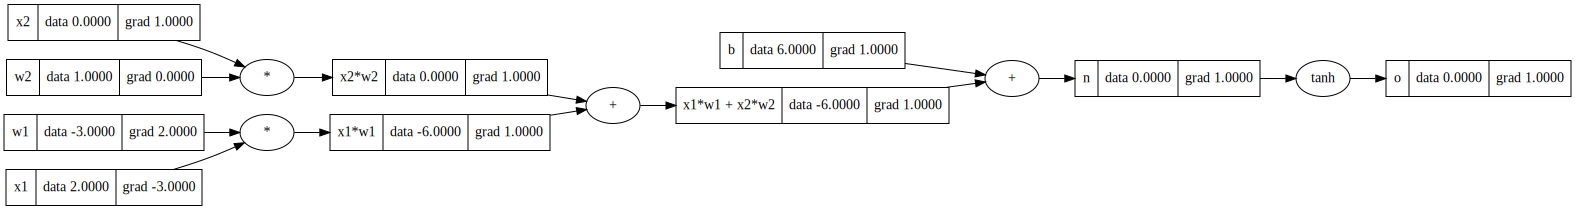

In [14]:
o.grad = 1.0 # base case
'''
Calling backward on o will change gradient of n
'''
o._backward()

'''
Calling backward on n will change gradient of x1w1 + x2w2 and b nodes
'''
n._backward()

'''
Calling backward on x1w1x2w2 will change gradient of x2w2 and x1w1
'''
x1w1x2w2._backward()
draw_dot(o)

'''
Calling backward on x1w1 and x1w1 will change gradient of x1, x2, w1 and w2
'''
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [15]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6),
 Value(data=0.0),
 Value(data=0.0)]

In [16]:
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0 # Replicating the base case
    for node in reversed(topo):
      node._backward()

# Attach the instance method to the class
Value.backward = backward

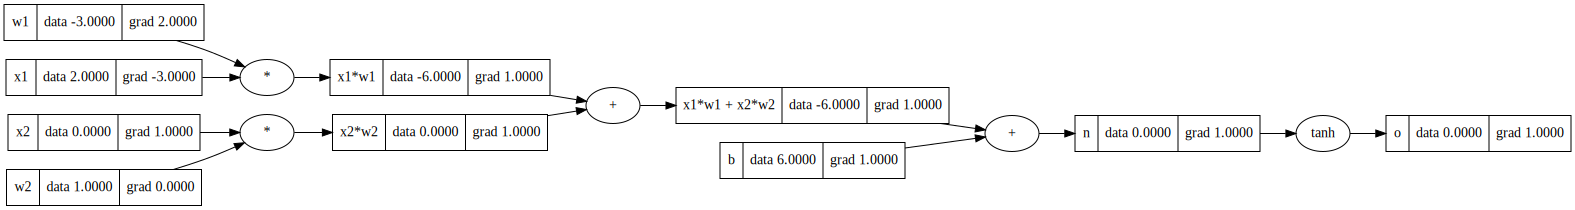

In [17]:
'''Reinitializing the values to reflect new class properties '''
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [18]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # requires_grad forces the tensor to be used in calculations of gradients
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.0
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


In [19]:
import random
class Neuron:
    def __init__(self, ninp):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(ninp)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        out = sum([ wi*xi for wi, xi in zip(self.w, x)]) + self.b
        res = out.tanh()
        return res

    def parameters(self): # This function would be used later on while training the network
        return self.w + [self.b]

In [20]:
x = [1.0, 2.0, 3.0 ]
n = Neuron(3)
n(x)

AttributeError: 'float' object has no attribute 'data'

In [21]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [22]:
'''
Trying out the above operation again
'''
x = [1.0, 2.0, 3.0 ]
n = Neuron(3)
n(x)

Value(data=0.925524588230414)

In [23]:
class Layer:
    def __init__(self, ninp, nneurons): # ninp is the number of inputs for each neuron in the layer
        self.neurons = [Neuron(ninp) for _ in range(nneurons)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [24]:
'''
Input x is passed through each neuron of layer l, hence 4 values output from the layer
'''
x = [1.0, 2.0, 3.0 ]
l = Layer(3, 4)
l(x)

[Value(data=-0.7433297734275653),
 Value(data=0.9996315051594864),
 Value(data=-0.21513988995714037),
 Value(data=0.6667176462902377)]

In [25]:
class MLP:
    def __init__(self, nin, nouts): # nin is the number of inputs for the first layer and nouts is an [] for output in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [26]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7946560013555771)

In [27]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [28]:
'''
Each x in xs would be passed to MLP, resulting in ypred, this is termed as forward pass
'''
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8017645718117261),
 Value(data=-0.8072075908939315),
 Value(data=-0.7000089040223608),
 Value(data=-0.8319897507039902)]

In [29]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.729705589595148)

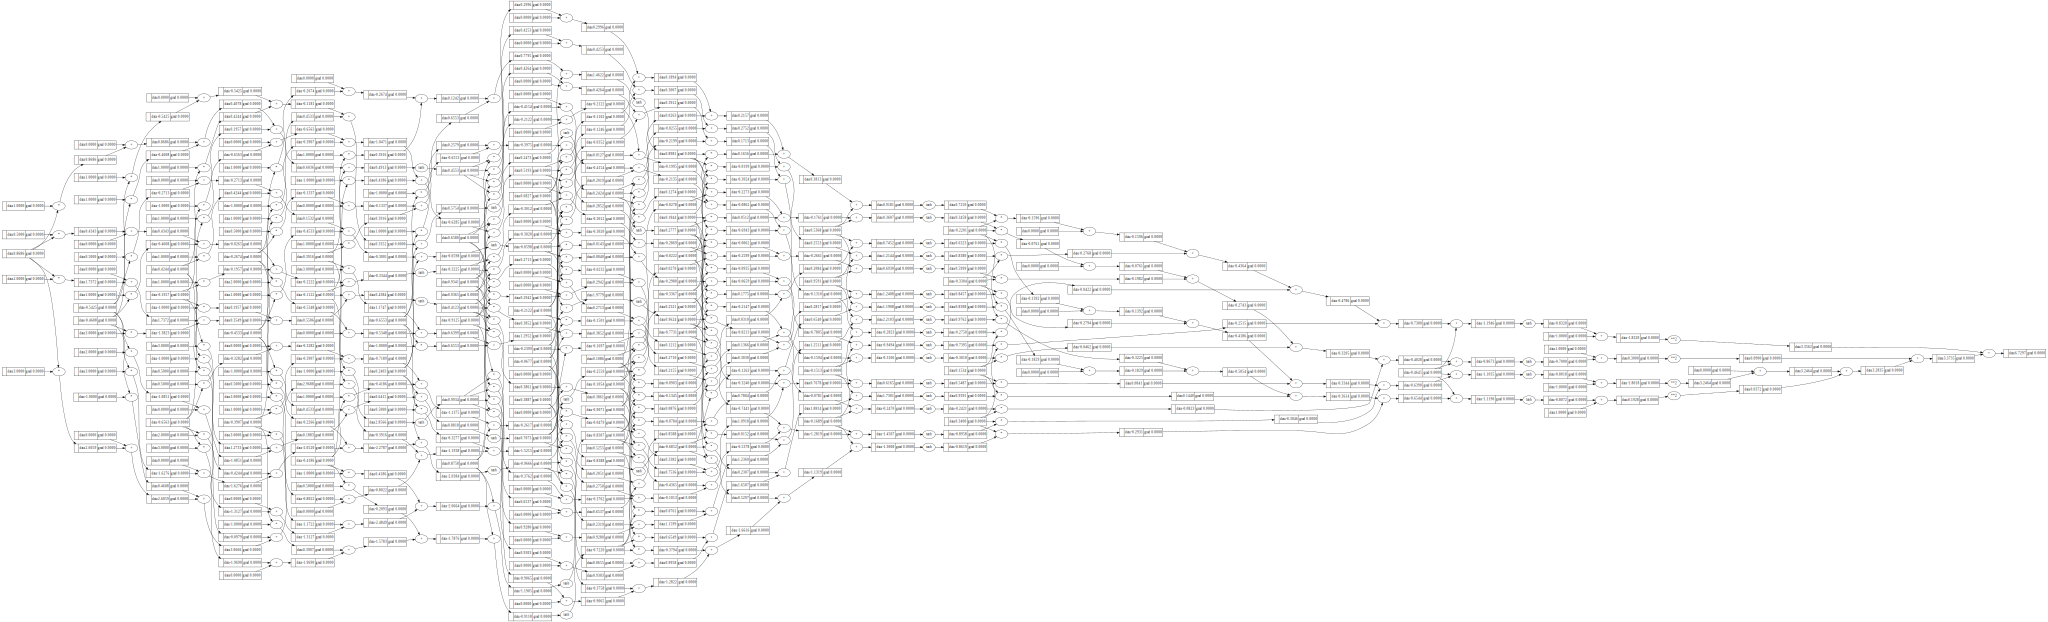

In [30]:
draw_dot(loss)

In [31]:
for p in n.parameters():
    p.data += -0.1 * p.grad

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.729705589595148)

In [32]:
'''
Resetting the values
'''
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [33]:
for k in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 6.3263374601895315
1 2.1727540992771255
2 1.0339804120910006
3 0.8114135178839943
4 0.19083055042349245
5 0.08722400251197009
6 0.07150553669787323
7 0.060865312394949085
8 0.05291702308898728
9 0.04671064662256406
10 0.04172574913143723
11 0.03763695614895301
12 0.03422636516431399
13 0.031341508641375096
14 0.02887223435594071
15 0.026736920298251053
16 0.024873801903940153
17 0.023235296359912786
18 0.02178417113376702
19 0.02049089024574744
20 0.019331735595210568
21 0.018287451380047514
22 0.017342249332497076
23 0.01648306764778214
24 0.015699011353667334
25 0.014980924452205883
26 0.014321059101683471
27 0.013712817173709053
28 0.013150546421334407
29 0.012629378298233459
30 0.012145097860969446
31 0.011694038612626082
32 0.011272996902501577
33 0.010879161782318333
34 0.010510057170430166
35 0.010163493885790117
36 0.009837529648753493
37 0.009530435552681045
38 0.009240667822066805
39 0.00896684391359553
40 0.008707722203668907
41 0.008462184652421692
42 0.00822922194964595


In [34]:
xs = [
  [4.0, 5.0, -3.0],
]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9810035758035763)]